## Homework #2
Due 9/23/2024

## Problem 1
Define a function to implement the peak-signal-to-noise calculation as described in lecture 4.  

Note: In python functions have the form:

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from statistics import geometric_mean, harmonic_mean
from scipy import signal

In [18]:
def peak_snr(original_image, new_image, color_flag=False):
    # This function will calculate the peak signal noise ratio between two equally sized images
    # From: https://dsp.stackexchange.com/questions/38065/peak-signal-to-noise-ratio-psnr-in-python-for-an-image
    mse = np.mean(np.square(np.subtract(original_image.astype(np.int16), new_image.astype(np.int16))))
    max = np.max(original_image)

    # return pSNR
    return 20*np.log10(max/np.sqrt(mse))

## Problem 2
* a) Implement a spatial frequency low-pass filter at 1/3 the Nyquist frequency of the image using a top-hat window (e.g. binary 0/1)
* b) Calculate the peak-SNR comparing the two images
* c) Use any image you like.  Put the image in the data folder for this repo 

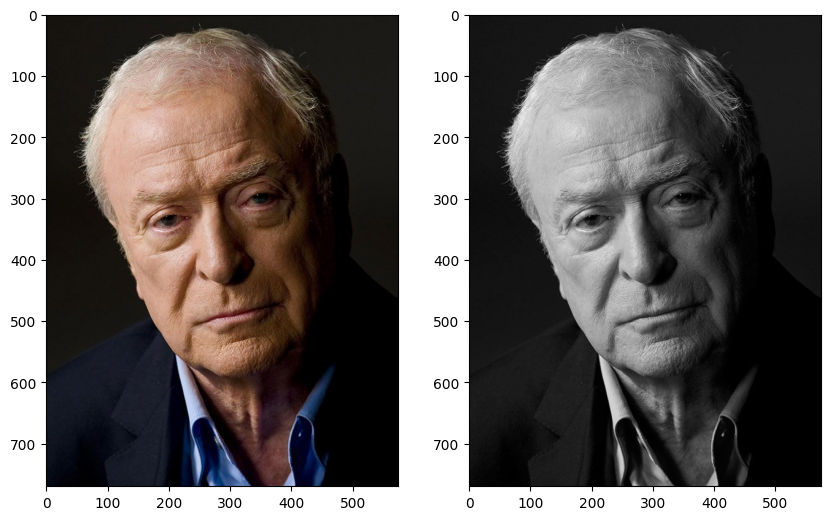

In [19]:
# start by loading the image
caine = cv2.imread('Data/Michael_Caine.jpg')
caine_rgb = cv2.cvtColor(caine, cv2.COLOR_BGR2RGB)
caine_gray = cv2.cvtColor(caine, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(caine_rgb)
plt.subplot(122), plt.imshow(caine_gray, cmap='gray')
plt.show()

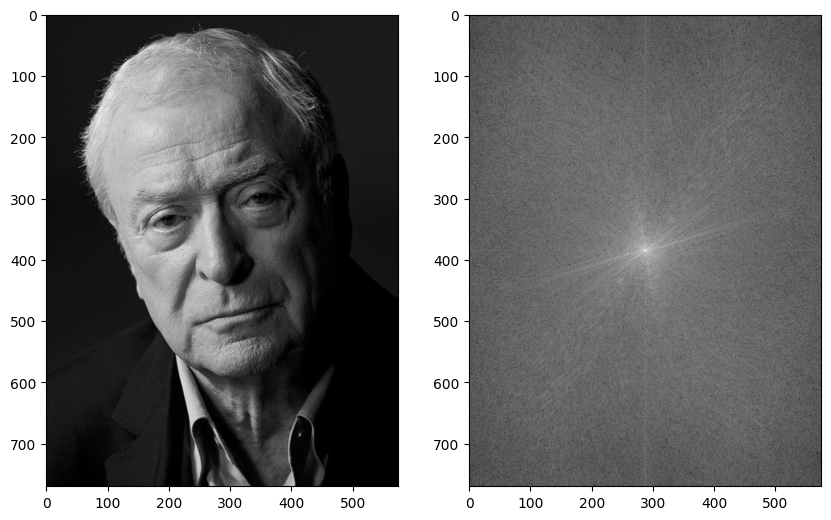

In [20]:
# apply DFT to image
# source: https://www.geeksforgeeks.org/how-to-find-the-fourier-transform-of-an-image-using-opencv-python/#

# apply DFT and shift zero-frequency to center
caine_fourier = cv2.dft(np.float32(caine_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
caine_fourier_shift = np.fft.fftshift(caine_fourier)

# calculate magnitude and display
caine_mag = 20*np.log(cv2.magnitude(caine_fourier_shift[:,:,0], caine_fourier_shift[:,:,1]))
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(caine_gray, cmap='gray')
plt.subplot(122), plt.imshow(caine_mag, cmap='gray')
plt.show()

In [21]:
# apply spacial frequency low pass filter
# find center of image to center filter
rows, cols, channel = caine_fourier_shift.shape
row_c, col_c = rows//2, cols//2

# calculate radius of 1/3 of image for filter
rad = np.minimum(row_c, col_c) / 3

# use ogrid for indicies, find distance and create mask
Y, X = np.ogrid[:rows, :cols]
dist = np.sqrt((X - col_c)**2 + (Y-row_c)**2)
filter_mask = dist <= rad

# apply mask
caine_mask = caine_fourier_shift.copy()
caine_mask[~filter_mask] = 0


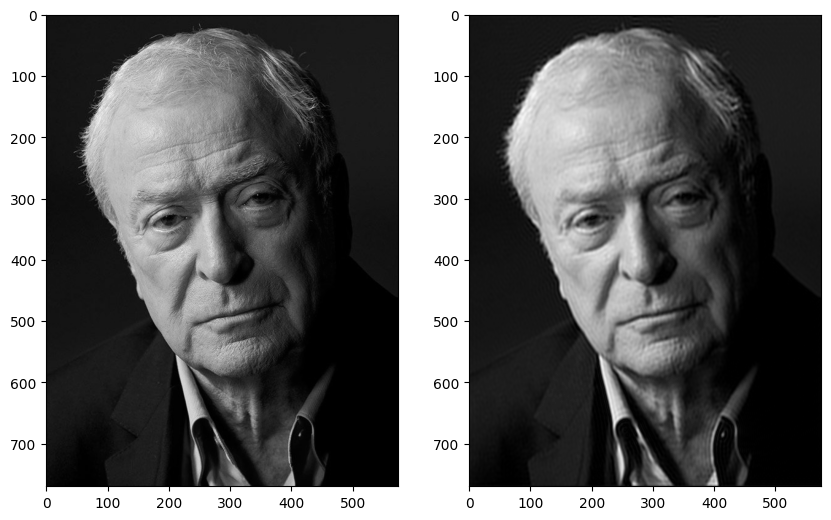

In [22]:
# apply inverse fft to and shift to return to spacial domain
caine_filtered = cv2.idft(np.fft.ifftshift(caine_mask))
caine_filtered = cv2.magnitude(caine_filtered[:,:,0], caine_filtered[:,:,1])
caine_filtered = cv2.normalize(caine_filtered, None, 0, 255, cv2.NORM_MINMAX)

# plot images
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(caine_gray, cmap='gray')
plt.subplot(122), plt.imshow(caine_filtered, cmap='gray')
plt.show()

In [23]:
# calculate the peak SNR ratio
print(f'Peak SNR: ',peak_snr(caine_gray, caine_filtered))

Peak SNR:  29.111639277268946


## Problem 3
Implement a similar low-pass filter as problem 2 (1/3 the Nyquist) in the spatial domain as a kernel convolution (e.g. using the sinc function definitions in lecture 5).  Use a top-hat window (e.g. without worrying about tapering the edges).  Use the same image you used in problem 2. 

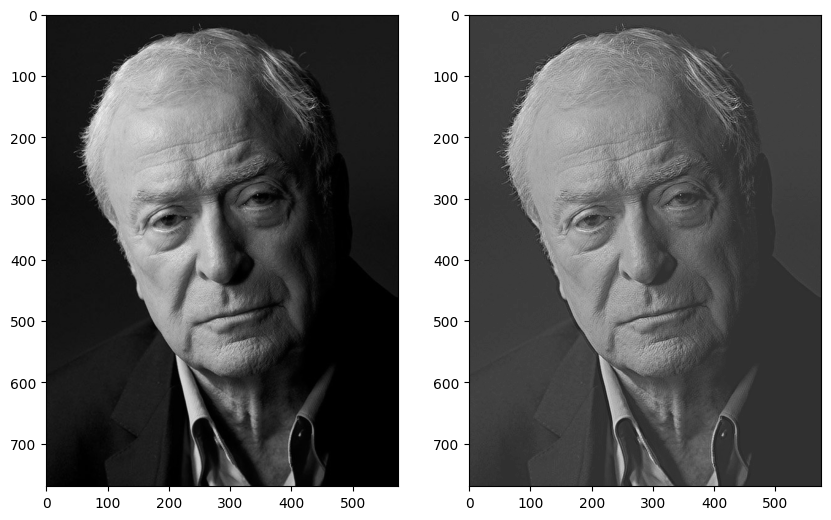

Peak SNR:  30.17924794757214


In [26]:
# implement low pass filter with kernel convolution
# nyquist cutoff frequency and window size
cutoff = 1/3
window_size = 11

# create sinc window
window_center = window_size//2
win_y, win_x = np.ogrid[-window_center:window_center+1, -window_center:window_center+1]
win_r = np.sqrt(win_x**2 + win_y**2)

# create window and handle center
sinc = np.sinc(2 * cutoff * win_r)
sinc[window_center, window_center] = 2 * np.pi * cutoff

# normalize kernel
win_kernel = sinc / np.sum(sinc)

# convolve image and kernel
caine_conv = signal.convolve2d(caine_gray, win_kernel, boundary='symm', mode='same')

# display images and SNR
plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(caine_gray, cmap='gray')
plt.subplot(122), plt.imshow(caine_conv, cmap='gray')
plt.show()
print(f'Peak SNR: ',peak_snr(caine_gray, caine_conv))


## Problem 4
Define a function to implement a mean smoothing kernel filter.  

[ECE1390]
* As an input to your function, allow the user to select between a arithmatic, geometric, or harmonic mean
* Assume a fixed 3x3 binary morphological kernel 

[ECE 2690]
* As an input to your function, allow the user to select between a arithmatic, geometric, harmonic mean, or contraharmonic mean ("m" should be an input parameter)
* Design your function to allow any arbitary binary morphological kernel 

C:\Users\tdhor\AppData\Local\Temp\ipykernel_31568\932074949.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  mean_value = len(value_list) / sum([1 / ele for ele in value_list])


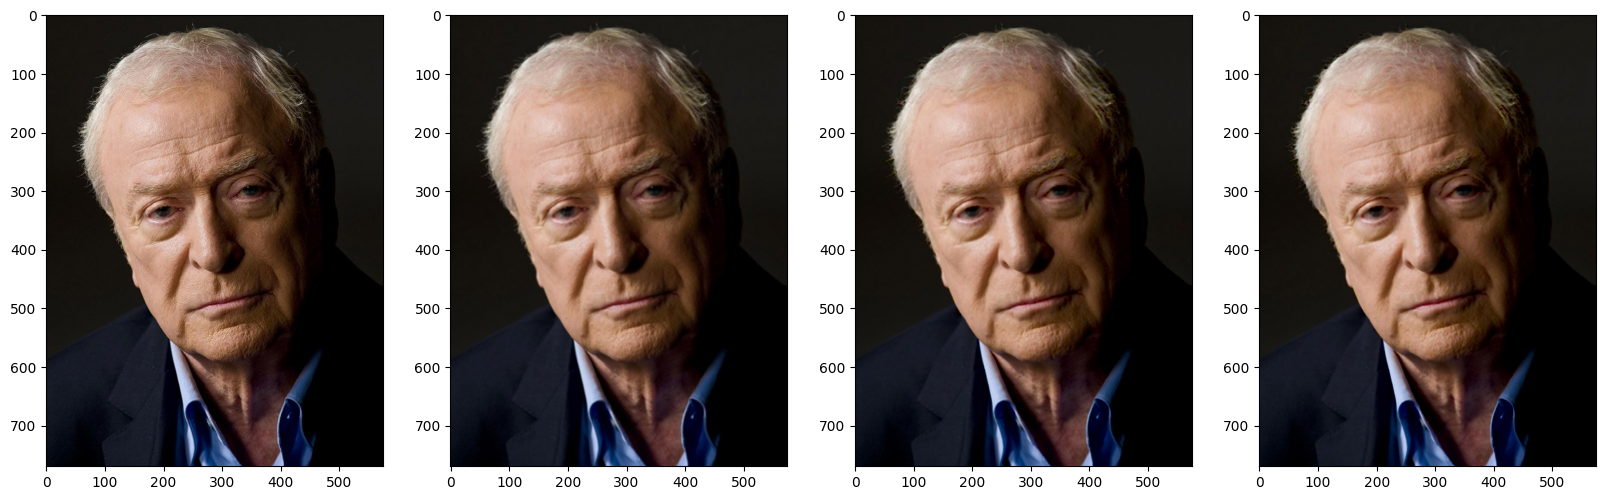

In [27]:
# function to implement smoothing kernel
# arithmatic = 0, geometric = 1, harmonic = 2
def mean_filter(original_image, m):
    # copy image and get shape
    output_image = original_image.copy()
    row = original_image.shape[0]
    column = original_image.shape[1]

    # hold filter values
    value_list = np.zeros(9)

    # loop through all pixels
    for r in range(1, row-1):
        for c in range(1, column-1):
            for val in range(3):

                # store pixel color intensities in all spots around image
                value_list[0] = (original_image[r-1, c-1, val])
                value_list[1] = (original_image[r,   c-1, val])
                value_list[2] = (original_image[r+1, c-1, val])
                value_list[3] = (original_image[r-1, c,   val])
                value_list[4] = (original_image[r,   c,   val])
                value_list[5] = (original_image[r+1, c,   val])
                value_list[6] = (original_image[r-1, c+1, val])
                value_list[7] = (original_image[r,   c+1, val])
                value_list[8] = (original_image[r+1, c+1, val])

                # find mean value and replace in output image
                if(m == 0):
                    mean_value = np.mean(value_list)
                if(m == 1):
                    mean_value = np.power(np.prod(value_list), 1/len(value_list))
                if(m == 2):
                    mean_value = len(value_list) / sum([1 / ele for ele in value_list])
                output_image[r, c, val] = mean_value

    return output_image

# could be made faster by storing color values themselves in value list making it 3x3x3 and calculating means that way
# plot images
plt.figure(figsize=(20,20))
plt.subplot(141), plt.imshow(caine_rgb)
plt.subplot(142), plt.imshow(mean_filter(caine_rgb, 0))
plt.subplot(143), plt.imshow(mean_filter(caine_rgb, 1))
plt.subplot(144), plt.imshow(mean_filter(caine_rgb, 2))
plt.show()

## Problem 5 [ECE 2390 only]
Define a function to compute the discrete cosine transform of an image.  Include code to pad the image appropriately. The equation for the DCT was given in lecture 4  